# Feed-Forward Layer 

After the **Attention Layer** allows tokens to "talk" to each other, the **Feed-Forward Layer** allows each token to "think" individually.

While Attention looks at the whole sequence, the FFN is **Position-wise**. It processes every token's vector independently and identically.

It consists of two linear transformations with a non-linear activation in between:
1.  **Expansion:** Project from Hidden Size ($H=768$) $\to$ Intermediate Size ($4H=3072$).
2.  **Activation:** Apply GELU (Gaussian Error Linear Unit).
3.  **Contraction:** Project from Intermediate Size ($3072$) $\to$ Hidden Size ($768$).

$$ FFN(x) = GELU(x W_1 + b_1) W_2 + b_2 $$

By projecting the data into a higher-dimensional space (3072), the model can "untangle" complex features that might be compressed in the lower-dimensional space (768), before compressing them back down.

Let's take a quick look at this. First, let's add _src_ to the python system path in case your notebook is not being run with it already added.

In [1]:
import sys
from pathlib import Path
sys.path.append((Path('').resolve().parent / 'src').as_posix())

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

# Import your model
from modules.feed_forward import FeedForwardLayer
from settings import BertSettings  # or BertSettings depending on your file

# Initialize Settings
settings = BertSettings(
    hidden_size=16,             # Small for visualization
    intermediate_size=64,       # 4x Expansion
    hidden_act="gelu",          # The BERT standard
    hidden_dropout_prob=0.0     # Disable dropout for deterministic results
)

### Inspecting the Weights
Let's look at the shapes of the matrices to verify the "Bottleneck" architecture (Small $\to$ Big $\to$ Small).

In [3]:
# Instantiate the layer
ffn = FeedForwardLayer(settings)

print(f"Expansion Weights:   {ffn.dense_expansion.weight.shape}")
print(f"Contraction Weights: {ffn.dense_contraction.weight.shape}")

# Verify the expansion ratio
assert ffn.dense_expansion.weight.shape[0] == settings.intermediate_size
print("\n✅ Correct expansion ratio (4x).")

Expansion Weights:   torch.Size([64, 16])
Contraction Weights: torch.Size([16, 64])

✅ Correct expansion ratio (4x).


### GELU vs ReLU
BERT uses **GELU** instead of the traditional **ReLU**.
* **ReLU** hard-clips everything below 0. This can lead to "Dead Neurons" (gradients stop flowing completely).
* **GELU** is smooth and allows small negative values (around -0.2) to pass through.

Let's visualize the difference. Since matplotlib is not a package requirement for our module, we will install it so we can use it now.

Using Python 3.13.3 environment at: /home/sergiofrayle/repos/personal/simple_bert/.venv
Audited 1 package in 2ms


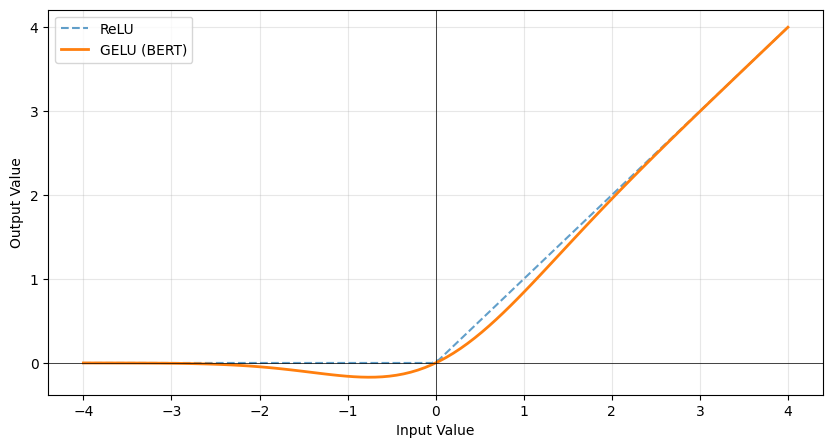

In [4]:
!uv pip install matplotlib

x = torch.linspace(-4, 4, 100)

relu = nn.ReLU()(x)
gelu = nn.GELU()(x)

plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), relu.numpy(), label="ReLU", linestyle="--", alpha=0.7)
plt.plot(x.numpy(), gelu.numpy(), label="GELU (BERT)", linewidth=2)
plt.xlabel("Input Value")
plt.ylabel("Output Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# Notice the "dip" below zero for GELU!

### Forward Pass
We will pass a batch of tokens through the layer.
* Input Shape: `(Batch=2, Seq=4, Hidden=16)`
* Expected Output: Same shape (due to the residual connection and contraction).

In [5]:
input_tensor = torch.randn(2, 4, settings.hidden_size)
output = ffn(input_tensor)

print(f"Input Shape:  {input_tensor.shape}")
print(f"Output Shape: {output.shape}")

assert input_tensor.shape == output.shape
print("\n✅ Shape preserved.")

# Verify values changed (Layer actually did something)
if not torch.allclose(input_tensor, output):
    print("✅ Values processed (Input != Output).")
else:
    print("❌ Error: Output equals Input (Layer is doing nothing!)")

Input Shape:  torch.Size([2, 4, 16])
Output Shape: torch.Size([2, 4, 16])

✅ Shape preserved.
✅ Values processed (Input != Output).
